# Grayscale Image Colorization

The project intends to realize automatic colorization of grayscale images. Workflows of the project is as follows.

![flowchart]('')

The CNN model employed here utilizes the structure of a ResNet18 model. First half of the model is transplanted from the first six layers of a ResNet18 model, so as to extract mid-level features of an image. Second half of the model is upsampling. For more details, please visit Luke Melas-Kyriazi's homepage(). The model here makes slight changes in  
+ definition of parsers: args.epochs is a parameter for number of epochs in a call of main(), not the index for maximum epochs in a call.
+ save checkpoints: save the best model only.
+ validation: plot log losses against epochs to have a better visulization of validation performance. MSE loss is used. 

Now Let's look at the model.

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision.models as models

import os, time, shutil, argparse
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, rgb2gray, lab2rgb
from skimage import io

from functools import partial
import pickle


### Define utilities

In [5]:
class AverageMeter(object):
    '''An easy way to compute and store both average and current values'''
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def visualize_image(grayscale_input, ab_input=None, show_image=False, save_path=None, save_name=None):
    '''Show or save image given grayscale (and ab color) inputs. Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib plot
    ab_input = ab_input.cpu()
    grayscale_input = grayscale_input.cpu()    
    if ab_input is None:
        grayscale_input = grayscale_input.squeeze().numpy() 
        if save_path is not None and save_name is not None: 
            plt.imsave(grayscale_input, '{}.{}'.format(save_path['grayscale'], save_name) , cmap='gray')
        if show_image: 
            plt.imshow(grayscale_input, cmap='gray')
            plt.show()
    else: 
        color_image = torch.cat((grayscale_input, ab_input), 0).numpy()
        color_image = color_image.transpose((1, 2, 0))  
        color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
        color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
        color_image = lab2rgb(color_image.astype(np.float64))
        grayscale_input = grayscale_input.squeeze().numpy()
        if save_path is not None and save_name is not None:
            plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
            plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))
        if show_image: 
            f, axarr = plt.subplots(1, 2)
            axarr[0].imshow(grayscale_input, cmap='gray')
            axarr[1].imshow(color_image)
            plt.show()

class GrayscaleImageFolder(datasets.ImageFolder):
    '''Custom images folder, which converts images to grayscale before loading'''
    def __getitem__(self, index):
        path, target = self.imgs[index]
        img = self.loader(path)
        if self.transform is not None:
            img_original = self.transform(img)
            img_original = np.asarray(img_original)
            img_lab = rgb2lab(img_original)
            img_lab = (img_lab + 128) / 255
            img_ab = img_lab[:, :, 1:3]
            img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
            img_original = rgb2gray(img_original)
            img_original = torch.from_numpy(img_original).unsqueeze(0).float()
        if self.target_transform is not None:
            target = self.target_transform(target)
        return img_original, img_ab, target

### Define CNN model

In [17]:
class ColorizationNet(nn.Module):
    def __init__(self, input_size=128):
        super(ColorizationNet, self).__init__()
        self.midlevel_feature_size = input_size

        ## First half: ResNet
        resnet = models.resnet18(num_classes=365) 
        # Change first conv layer to accept single-channel (grayscale) input
        resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1)) 
        # Extract midlevel features from ResNet-gray
        self.midlevel_resnet = nn.Sequential(*list(resnet.children())[0:6])

        ## Second half: Upsampling
        self.upsample = nn.Sequential(
            nn.Conv2d(self.midlevel_feature_size, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, input):

        # Pass input through ResNet-gray to extract features
        midlevel_features = self.midlevel_resnet(input)

        # Upsample to get colors
        output = self.upsample(midlevel_features)
        return output

### Define train mode and evaluation mode(validation/test) utilized in main()

In [8]:
def train(train_loader, model, criterion, optimizer, epoch):
    '''Train model on data in train_loader for a single epoch'''
    print('Starting training epoch {}'.format(epoch))

    # Prepare value counters and timers
    batch_time = AverageMeter()
    losses = AverageMeter()
    
    # Switch model to train mode
    model.train()
    
    # Train for single epoch
    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(train_loader):
        
        # Use GPU if available
        input_gray_variable = Variable(input_gray).cuda() if use_gpu else Variable(input_gray)
        input_ab_variable = Variable(input_ab).cuda() if use_gpu else Variable(input_ab)
        target_variable = Variable(target).cuda() if use_gpu else Variable(target)

        # Run forward pass
        output_ab = model(input_gray_variable) # throw away class predictions
        loss = criterion(output_ab, input_ab_variable) # MSE
        
        # Record loss and measure accuracy
        losses.update(loss.data[0], input_gray.size(0))
        
        # Compute gradient and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Record time to do forward and backward passes
        batch_time.update(time.time() - end)
        end = time.time()
        
        # Print model accuracy
        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                      epoch, i+1, len(train_loader), batch_time=batch_time,
                      loss=losses)) 

    print('Finished training epoch {}'.format(epoch))

def Evaluate(eval_loader, model, criterion, save_images, epoch, mode):
    '''Evaluate model on data in eval_loader, mode = 'Validation' or 'Test' ''' 
    print('Starting {}.'.format(mode))

    # Prepare value counters and timers
    batch_time = AverageMeter()
    losses = AverageMeter()
    
    # Switch model to validation mode
    model.eval()
    
    # Run through validation set
    end = time.time()
    for i, (input_gray, input_ab, target) in enumerate(eval_loader):
        
        # Use GPU if available
        target = target.cuda() if use_gpu else target
        input_gray_variable = Variable(input_gray, volatile=True).cuda() if use_gpu else Variable(input_gray, volatile=True)
        input_ab_variable = Variable(input_ab, volatile=True).cuda() if use_gpu else Variable(input_ab, volatile=True)
        target_variable = Variable(target, volatile=True).cuda() if use_gpu else Variable(target, volatile=True)

        # Run forward pass
        output_ab = model(input_gray_variable) # throw away class predictions
        loss = criterion(output_ab, input_ab_variable) # check this!
        
        # Record loss and measure accuracy
        losses.update(loss.data[0], input_gray.size(0))

        # Save images to file
        if save_images:
            for j in range(len(output_ab)):
                save_path = {'grayscale': 'outputs/'+mode+'/gray/', 'colorized': 'outputs/'+mode+'/color/'}
                save_name = 'img-{}-epoch-{}.jpg'.format(i * eval_loader.batch_size + j, epoch)
                visualize_image(input_gray[j], ab_input=output_ab[j].data, show_image=True, save_path=save_path, save_name=save_name)

        # Record time to do forward passes and save images
        batch_time.update(time.time() - end)
        end = time.time()
        
        # Print model accuracy
        if i+1 % args.print_freq == 0:
            print('Evaluate: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
                   i+1, len(eval_loader), batch_time=batch_time, loss=losses))

    print('Finished {}.'.format(mode))
    return losses.avg          

### Define main()

In [9]:
def main():
    global args, best_losses, use_gpu
    
    # Create model  # models.resnet18(num_classes=365)
    model = ColorizationNet()
    
    # Use GPU if available
    if use_gpu:
        model.cuda()
        print('Loaded model onto GPU.')
    
    # Create loss function, optimizer #criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
    criterion = nn.MSELoss().cuda() if use_gpu else nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.weight_decay)

    # Resume from checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print('Loading checkpoint {}...'.format(args.resume))
            checkpoint = torch.load(args.resume) if use_gpu else torch.load(args.resume, map_location=lambda storage, loc: storage)
            args.start_epoch = checkpoint['epoch']
            best_losses = checkpoint['best_losses']
            model.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            print('Finished loading checkpoint. Resuming from epoch {}'.format(checkpoint['epoch']))
        else:
            print('Checkpoint filepath incorrect.')

    # If in test mode, do not train
    if args.test:
        test_transforms = transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(256)
        ])
        test_directory = os.path.join(args.data, 'test')
        test_imagefolder = GrayscaleImageFolder(test_directory , test_transforms)
        test_loader = torch.utils.data.DataLoader(test_imagefolder, batch_size=args.batch_size, shuffle=False)
        print('Loaded test data.')
        losses_test = Evaluate(test_loader, model, criterion, True, args.start_epoch, 'Test')
        return losses_test.item()

    # Otherwise, train for given number of epochs
    
    # Load data from pre-defined (imagenet-style) structure
    if not args.test:
        train_directory = os.path.join(args.data, 'train')
        train_transforms = transforms.Compose([
            transforms.RandomSizedCrop(256),
            transforms.RandomHorizontalFlip()
        ])
        train_imagefolder = GrayscaleImageFolder(train_directory, train_transforms)
        train_loader = torch.utils.data.DataLoader(train_imagefolder, batch_size=args.batch_size, shuffle=True)
        print('Loaded training data.')
        
        val_transforms = transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(256)
        ])
        val_directory = os.path.join(args.data, 'val')
        val_imagefolder = GrayscaleImageFolder(val_directory , val_transforms)
        val_loader = torch.utils.data.DataLoader(val_imagefolder, batch_size=args.batch_size, shuffle=False)
        print('Loaded evaluation data.')

    losses_validation = []
    for epoch in range(args.start_epoch, args.start_epoch+args.epochs):
        
        # Train for one epoch, then validate
        train(train_loader, model, criterion, optimizer, epoch)
#        save_images = True #(epoch % 3 == 0)
        losses = Evaluate(val_loader, model, criterion, False, epoch, 'Validation').item()
        losses_validation.append(losses)
        
        # Save checkpoint, and replace the old best model if the current model is better
        is_best_so_far = losses < best_losses
        best_losses = min(losses, best_losses)
        if is_best_so_far:
            torch.save({
                'epoch': epoch + 1,
                'best_losses': best_losses,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            },'checkpoints/model_best.pth.tar')

# plot validation performance

    num_epoch = np.arange(args.start_epoch+1, args.start_epoch+args.epochs+1, 1)        
    fig,ax = plt.subplots()
    ax.plot(num_epoch, np.log(losses_validation))
    ax.set_xlabel('number of epochs')
    ax.set_ylabel('log loss')
    plt.show()
    return best_losses

### Define parsers to call main()
Some of parsers are hyperparameters for the CNN model, i.e. batch size, learning rate, weight decay.

In [20]:
# Parse arguments and prepare program
parser = argparse.ArgumentParser(description='Training and Using ColorNet')
parser.add_argument('-data', default='', type=str, metavar='DIR', help='path to dataset')
parser.add_argument('--resume', default='checkpoints/model_best.pth.tar', type=str, metavar='PATH', help='path to .pth file checkpoint (default: none)')
parser.add_argument('--epochs', default=10, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('-st','--start-epoch', default=0, type=int, metavar='N', help='manual epoch number (overridden if loading from checkpoint)')
parser.add_argument('-b', '--batch-size', default=16, type=int, metavar='N', help='size of mini-batch (default: 16)')
parser.add_argument('--lr', '--learning-rate', default=0.1, type=float, metavar='LR', help='learning rate at start of training')
parser.add_argument('--weight-decay', '--wd', default=1e-4, type=float, metavar='W', help='weight decay (default: 1e-4)')
parser.add_argument('-t', '--test', default=False, type=bool, metavar='Test', help='use this flag to test')
parser.add_argument('--print-freq', '-p', default=5, type=int, metavar='N', help='print frequency (default: 5)')
parser.add_argument('-f', '--for', default='', type=str, metavar='N', help='for tests')

_StoreAction(option_strings=['-f', '--for'], dest='for', nargs=None, const=None, default='', type=<class 'str'>, choices=None, help='for tests', metavar='N')

### Run the model
Size of training set/validation set/test set = 16/8/4.

In [10]:
args = parser.parse_args()
print('Arguments: {}'.format(args))

best_losses = 1000.0
use_gpu = torch.cuda.is_available()

Arguments: Namespace(batch_size=16, data='', epochs=10, for='/Users/aaronwg/Library/Jupyter/runtime/kernel-2574317b-4a70-4b20-8895-c085c83bc29a.json', lr=0.1, print_freq=5, resume='checkpoints/model_best.pth.tar', start_epoch=0, test=False, weight_decay=0.0001)


#### Default (50 epochs)

Checkpoint filepath incorrect.
Loaded training data.
Loaded evaluation data.
Starting training epoch 0


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [0][1/1]	Time 7.974 (7.974)	Loss 0.2895 (0.2895)	
Finished training epoch 0
Starting Validation.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Evaluate: [1/1]	Time 1.487 (1.487)	Loss 476883498411282418106368.0000 (476883498411282418106368.0000)	
Finished Validation.
Starting training epoch 1
Epoch: [1][1/1]	Time 7.977 (7.977)	Loss 40.6318 (40.6318)	
Finished training epoch 1
Starting Validation.
Evaluate: [1/1]	Time 1.449 (1.449)	Loss 742460971662253752320.0000 (742460971662253752320.0000)	
Finished Validation.
Starting training epoch 2
Epoch: [2][1/1]	Time 8.250 (8.250)	Loss 2.5848 (2.5848)	
Finished training epoch 2
Starting Validation.
Evaluate: [1/1]	Time 1.520 (1.520)	Loss 41928063449038848.0000 (41928063449038848.0000)	
Finished Validation.
Starting training epoch 3
Epoch: [3][1/1]	Time 7.820 (7.820)	Loss 1.6564 (1.6564)	
Finished training epoch 3
Starting Validation.
Evaluate: [1/1]	Time 1.472 (1.472)	Loss 367137461895168.0000 (367137461895168.0000)	
Finished Validation.
Starting training epoch 4
Epoch: [4][1/1]	Time 7.980 (7.980)	Loss 2.8012 (2.8012)	
Finished training epoch 4
Starting Validation.
Evaluate: [1/1]	Time

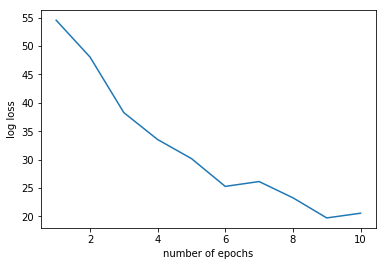

1000.0

In [11]:
main()

#### 50 more epochs, resumed from the best model in the last call of main()

Checkpoint filepath incorrect.
Loaded training data.
Loaded evaluation data.
Starting training epoch 0


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [0][1/1]	Time 7.894 (7.894)	Loss 0.5771 (0.5771)	
Finished training epoch 0
Starting Validation.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Evaluate: [1/1]	Time 1.734 (1.734)	Loss 6182212294072501193303654400.0000 (6182212294072501193303654400.0000)	
Finished Validation.
Starting training epoch 1
Epoch: [1][1/1]	Time 7.994 (7.994)	Loss 10.0977 (10.0977)	
Finished training epoch 1
Starting Validation.
Evaluate: [1/1]	Time 1.806 (1.806)	Loss 6153658717406494720.0000 (6153658717406494720.0000)	
Finished Validation.
Starting training epoch 2
Epoch: [2][1/1]	Time 7.864 (7.864)	Loss 0.5512 (0.5512)	
Finished training epoch 2
Starting Validation.
Evaluate: [1/1]	Time 1.673 (1.673)	Loss 147808313147392.0000 (147808313147392.0000)	
Finished Validation.
Starting training epoch 3
Epoch: [3][1/1]	Time 7.819 (7.819)	Loss 0.3475 (0.3475)	
Finished training epoch 3
Starting Validation.
Evaluate: [1/1]	Time 1.604 (1.604)	Loss 2171386462208.0000 (2171386462208.0000)	
Finished Validation.
Starting training epoch 4
Epoch: [4][1/1]	Time 7.472 (7.472)	Loss 0.6875 (0.6875)	
Finished training epoch 4
Starting Validation.
Evaluate: [1/1]	Time 1.6

Evaluate: [1/1]	Time 1.567 (1.567)	Loss 3.3508 (3.3508)	
Finished Validation.
Starting training epoch 39
Epoch: [39][1/1]	Time 7.652 (7.652)	Loss 0.1517 (0.1517)	
Finished training epoch 39
Starting Validation.
Evaluate: [1/1]	Time 1.634 (1.634)	Loss 2.3542 (2.3542)	
Finished Validation.
Starting training epoch 40
Epoch: [40][1/1]	Time 7.723 (7.723)	Loss 0.0914 (0.0914)	
Finished training epoch 40
Starting Validation.
Evaluate: [1/1]	Time 1.638 (1.638)	Loss 1.0129 (1.0129)	
Finished Validation.
Starting training epoch 41
Epoch: [41][1/1]	Time 7.751 (7.751)	Loss 0.0170 (0.0170)	
Finished training epoch 41
Starting Validation.
Evaluate: [1/1]	Time 1.564 (1.564)	Loss 0.3591 (0.3591)	
Finished Validation.
Starting training epoch 42
Epoch: [42][1/1]	Time 7.684 (7.684)	Loss 0.0111 (0.0111)	
Finished training epoch 42
Starting Validation.
Evaluate: [1/1]	Time 1.621 (1.621)	Loss 0.1453 (0.1453)	
Finished Validation.
Starting training epoch 43
Epoch: [43][1/1]	Time 7.809 (7.809)	Loss 0.0105 (0.

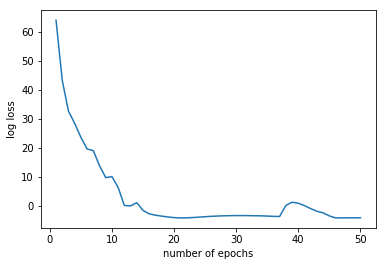

0.01474214717745781

In [13]:
args.epochs = 50
main()

#### Test model performance

Loading checkpoint checkpoints/model_best.pth.tar...
Finished loading checkpoint. Resuming from epoch 21
Loaded test data.
Starting Test.


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel

<Figure size 432x288 with 0 Axes>

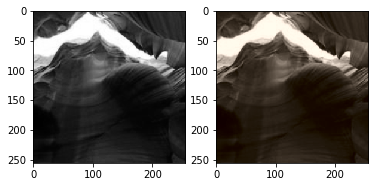

<Figure size 432x288 with 0 Axes>

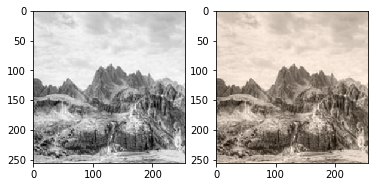

<Figure size 432x288 with 0 Axes>

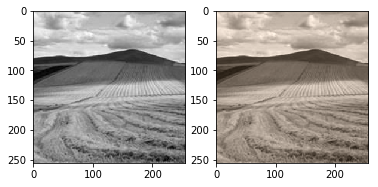

<Figure size 432x288 with 0 Axes>

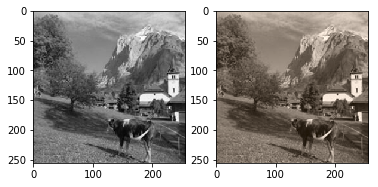

Evaluate: [1/1]	Time 1.720 (1.720)	Loss 0.0065 (0.0065)	
Finished Test.


0.006511623039841652

In [15]:
args.test = True
main()

#### More epochs and test

Loading checkpoint checkpoints/model_best.pth.tar...
Finished loading checkpoint. Resuming from epoch 21
Loaded training data.
Loaded evaluation data.
Starting training epoch 21


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [21][1/1]	Time 7.677 (7.677)	Loss 0.0125 (0.0125)	
Finished training epoch 21
Starting Validation.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Evaluate: [1/1]	Time 1.613 (1.613)	Loss 0.0150 (0.0150)	
Finished Validation.
Starting training epoch 22
Epoch: [22][1/1]	Time 7.984 (7.984)	Loss 0.0146 (0.0146)	
Finished training epoch 22
Starting Validation.
Evaluate: [1/1]	Time 1.635 (1.635)	Loss 0.0167 (0.0167)	
Finished Validation.
Starting training epoch 23
Epoch: [23][1/1]	Time 7.825 (7.825)	Loss 0.0190 (0.0190)	
Finished training epoch 23
Starting Validation.
Evaluate: [1/1]	Time 1.481 (1.481)	Loss 0.0193 (0.0193)	
Finished Validation.
Starting training epoch 24
Epoch: [24][1/1]	Time 7.042 (7.042)	Loss 0.0223 (0.0223)	
Finished training epoch 24
Starting Validation.
Evaluate: [1/1]	Time 1.475 (1.475)	Loss 0.0223 (0.0223)	
Finished Validation.
Starting training epoch 25
Epoch: [25][1/1]	Time 6.978 (6.978)	Loss 0.0201 (0.0201)	
Finished training epoch 25
Starting Validation.
Evaluate: [1/1]	Time 1.660 (1.660)	Loss 0.0254 (0.0254)	
Finished Validation.
Starting training epoch 26
Epoch: [26][1/1]	Time 7.911 (7.911)	Loss 0.0251 (0.

Evaluate: [1/1]	Time 1.559 (1.559)	Loss 0.0153 (0.0153)	
Finished Validation.
Starting training epoch 61
Epoch: [61][1/1]	Time 7.784 (7.784)	Loss 0.0084 (0.0084)	
Finished training epoch 61
Starting Validation.
Evaluate: [1/1]	Time 1.609 (1.609)	Loss 0.0151 (0.0151)	
Finished Validation.
Starting training epoch 62
Epoch: [62][1/1]	Time 7.568 (7.568)	Loss 0.0085 (0.0085)	
Finished training epoch 62
Starting Validation.
Evaluate: [1/1]	Time 1.615 (1.615)	Loss 0.0150 (0.0150)	
Finished Validation.
Starting training epoch 63
Epoch: [63][1/1]	Time 7.876 (7.876)	Loss 0.0085 (0.0085)	
Finished training epoch 63
Starting Validation.
Evaluate: [1/1]	Time 1.568 (1.568)	Loss 0.0148 (0.0148)	
Finished Validation.
Starting training epoch 64
Epoch: [64][1/1]	Time 7.859 (7.859)	Loss 0.0087 (0.0087)	
Finished training epoch 64
Starting Validation.
Evaluate: [1/1]	Time 1.581 (1.581)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 65
Epoch: [65][1/1]	Time 7.583 (7.583)	Loss 0.0090 (0.

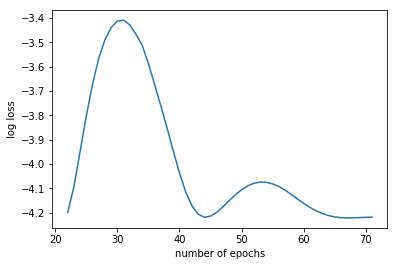

0.01468687690794468

In [16]:
args.epochs = 50
args.test = False
main()

Loading checkpoint checkpoints/model_best.pth.tar...
Finished loading checkpoint. Resuming from epoch 67
Loaded test data.
Starting Test.


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel

<Figure size 432x288 with 0 Axes>

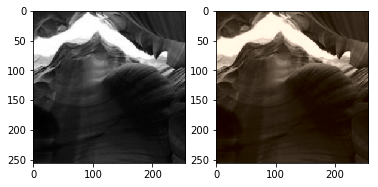

<Figure size 432x288 with 0 Axes>

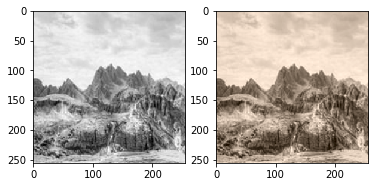

<Figure size 432x288 with 0 Axes>

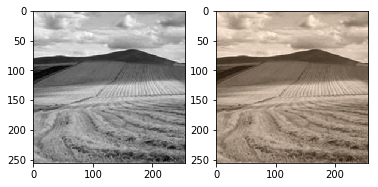

<Figure size 432x288 with 0 Axes>

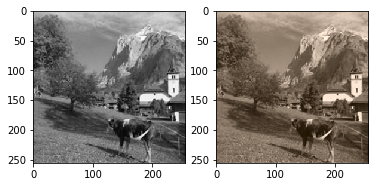

Evaluate: [1/1]	Time 1.723 (1.723)	Loss 0.0062 (0.0062)	
Finished Test.


0.006210825406014919

In [18]:
args.test = True
main()

Loading checkpoint checkpoints/model_best.pth.tar...
Finished loading checkpoint. Resuming from epoch 67
Loaded training data.
Loaded evaluation data.
Starting training epoch 67


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:563: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
  "please use transforms.RandomResizedCrop instead.")
/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch: [67][1/1]	Time 7.786 (7.786)	Loss 0.0091 (0.0091)	
Finished training epoch 67
Starting Validation.


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:73: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Evaluate: [1/1]	Time 1.657 (1.657)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 68
Epoch: [68][1/1]	Time 8.446 (8.446)	Loss 0.0088 (0.0088)	
Finished training epoch 68
Starting Validation.
Evaluate: [1/1]	Time 1.612 (1.612)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 69
Epoch: [69][1/1]	Time 7.739 (7.739)	Loss 0.0087 (0.0087)	
Finished training epoch 69
Starting Validation.
Evaluate: [1/1]	Time 1.589 (1.589)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 70
Epoch: [70][1/1]	Time 7.798 (7.798)	Loss 0.0089 (0.0089)	
Finished training epoch 70
Starting Validation.
Evaluate: [1/1]	Time 1.631 (1.631)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 71
Epoch: [71][1/1]	Time 7.686 (7.686)	Loss 0.0097 (0.0097)	
Finished training epoch 71
Starting Validation.
Evaluate: [1/1]	Time 1.578 (1.578)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 72
Epoch: [72][1/1]	Time 7.638 (7.638)	Loss 0.0094 (0.

Evaluate: [1/1]	Time 1.559 (1.559)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 107
Epoch: [107][1/1]	Time 7.735 (7.735)	Loss 0.0089 (0.0089)	
Finished training epoch 107
Starting Validation.
Evaluate: [1/1]	Time 1.630 (1.630)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 108
Epoch: [108][1/1]	Time 7.711 (7.711)	Loss 0.0085 (0.0085)	
Finished training epoch 108
Starting Validation.
Evaluate: [1/1]	Time 1.644 (1.644)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 109
Epoch: [109][1/1]	Time 7.921 (7.921)	Loss 0.0086 (0.0086)	
Finished training epoch 109
Starting Validation.
Evaluate: [1/1]	Time 1.659 (1.659)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 110
Epoch: [110][1/1]	Time 8.331 (8.331)	Loss 0.0091 (0.0091)	
Finished training epoch 110
Starting Validation.
Evaluate: [1/1]	Time 1.659 (1.659)	Loss 0.0147 (0.0147)	
Finished Validation.
Starting training epoch 111
Epoch: [111][1/1]	Time 7.966 (7.966)	L

Epoch: [145][1/1]	Time 7.739 (7.739)	Loss 0.0094 (0.0094)	
Finished training epoch 145
Starting Validation.
Evaluate: [1/1]	Time 1.658 (1.658)	Loss 0.0148 (0.0148)	
Finished Validation.
Starting training epoch 146
Epoch: [146][1/1]	Time 7.854 (7.854)	Loss 0.0068 (0.0068)	
Finished training epoch 146
Starting Validation.
Evaluate: [1/1]	Time 1.652 (1.652)	Loss 0.0148 (0.0148)	
Finished Validation.
Starting training epoch 147
Epoch: [147][1/1]	Time 7.725 (7.725)	Loss 0.0094 (0.0094)	
Finished training epoch 147
Starting Validation.
Evaluate: [1/1]	Time 1.638 (1.638)	Loss 0.0148 (0.0148)	
Finished Validation.
Starting training epoch 148
Epoch: [148][1/1]	Time 7.732 (7.732)	Loss 0.0078 (0.0078)	
Finished training epoch 148
Starting Validation.
Evaluate: [1/1]	Time 1.569 (1.569)	Loss 0.0148 (0.0148)	
Finished Validation.
Starting training epoch 149
Epoch: [149][1/1]	Time 7.876 (7.876)	Loss 0.0099 (0.0099)	
Finished training epoch 149
Starting Validation.
Evaluate: [1/1]	Time 1.606 (1.606)	L

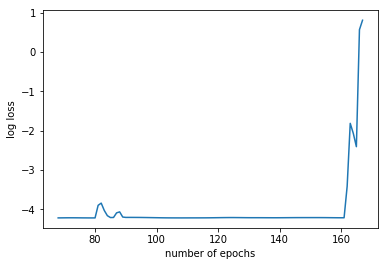

0.014684082940220833

In [19]:
args.epochs = 100
args.test = False
main()

Loading checkpoint checkpoints/model_best.pth.tar...
Finished loading checkpoint. Resuming from epoch 79
Loaded test data.
Starting Test.


/anaconda3/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:64: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:65: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:66: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/anaconda3/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")
/anaconda3/lib/python3.6/site-packages/ipykernel

<Figure size 432x288 with 0 Axes>

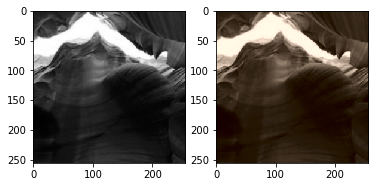

<Figure size 432x288 with 0 Axes>

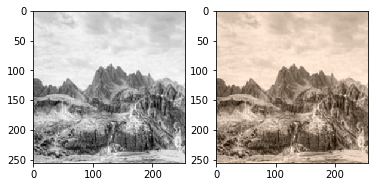

<Figure size 432x288 with 0 Axes>

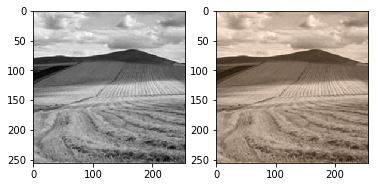

<Figure size 432x288 with 0 Axes>

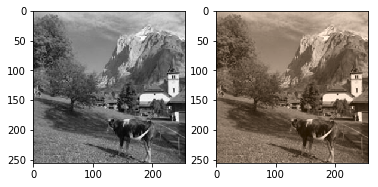

Evaluate: [1/1]	Time 1.649 (1.649)	Loss 0.0062 (0.0062)	
Finished Test.


0.0061839246191084385

In [21]:
args.test = True
main()

## Comments

+ Model performace is not satisfactory.
+ A possible reason is that training/validation set is of too small size. When the model is trained on 228 images, validated on 36 images, and tested on 36 images, there is still little improvement.  To further enlarge size of data sets is expected to be an improvement. 
+ Use k-fold validation instead of hold-out method. 
+ It may be better to increase layers borrowed from the ResNet18 model, so that deeper features of images can be extracted.

## Reference

Luke Melas-Kyriazi (https://lukemelas.github.io/)